# INITIALIZATION 🆕

In [1]:
# supporting libraries
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from tqdm.notebook import tqdm

# deep learning libraries and modules
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

c:\Users\sgoswam\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [7]:
# Here the test split is 10% of the data, and the validation split is 10% of the remaining training data
TEST_SPLIT = 0.15
VAL_SPLIT = 0.20

# Building the Database 🧩

In [2]:
tf.keras.backend.clear_session()


df = pd.read_csv(
    "data/SeoulBikeData.csv",
    encoding_errors='ignore',
    header = 0,
    names = [
        'Date', 'RentedBikeCount', 'Hour', 'Temperature', 'Humidity',
        'Windspeed', 'Visibility', 'DewPointTemperature', 'SolarRadiation',
        'Rainfall', 'Snowfall', 'Seasons', 'Holiday', 'FunctionalDay'
    ],
    dtype={
        'Date': 'str',
        'RentedBikeCount': 'int',
        'Hour': 'int',
        'Temperature': 'float',
        'Humidity': 'int',
        'Windspeed': 'float',
        'Visibility': 'int',
        'DewPointTemperature': 'float',
        'SolarRadiation': 'float',
        'Rainfall': 'float',
        'Snowfall': 'float',
        'Seasons': 'str',
        'Holiday': 'str',
        'FunctionalDay': 'str'
    }
)

# Checking for null values
print("Null Value columns in the dataset: ")
df.isnull().sum()

# Converting the date column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format = '%d/%m/%Y')

df['DayMonth'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month_name()
# df['Year'] = df['Date'].dt.year       # Not using year as a feature, since we don't have enough data for multiple years
df['DayWeek'] = df['Date'].dt.day_name()
df['DayYear'] = df['Date'].dt.dayofyear

# Creating a list of features to be used in the model
target = ['RentedBikeCount']
binary_features = ['Holiday', 'FunctionalDay']
numeric_features = [
    'Hour', 'Temperature', 'Humidity', 'Windspeed',
    'Visibility', 'DewPointTemperature', 'SolarRadiation',
    'Rainfall', 'Snowfall', 'DayMonth', 'DayYear'
]
categorical_features = ['Seasons', 'Month', 'DayWeek']
features = binary_features + numeric_features + categorical_features


# Standardizing the numeric features using sklearn's StandardScaler
scaler = StandardScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])

# Encoding the Binary features using sklearn's OneHotEncoder
ohe_encoder = make_column_transformer(
    (OneHotEncoder(), binary_features), remainder = 'passthrough'
)
transformed = ohe_encoder.fit_transform(df[binary_features])
df_ohe = pd.DataFrame(transformed, columns=ohe_encoder.get_feature_names() )
ohe_binary_features = df_ohe.columns.tolist()
df[ohe_binary_features] = df_ohe

# Encoding the Categorical features using sklearn's OneHotEncoder
ohe_encoder = make_column_transformer(
    (OneHotEncoder(), categorical_features), remainder = 'passthrough'
)
transformed = ohe_encoder.fit_transform(df[categorical_features])
df_ohe = pd.DataFrame(transformed.toarray(), columns=ohe_encoder.get_feature_names() )
ohe_categorical_features = df_ohe.columns.tolist()
df[ohe_categorical_features] = df_ohe

encoded_features = ohe_binary_features + numeric_features + ohe_categorical_features

df[encoded_features + target] = df[encoded_features + target].astype('float64')



train_df, test_df = train_test_split(
    df[encoded_features + target], test_size=TEST_SPLIT,
    random_state=42, shuffle=True
)
train_df, val_df = train_test_split(
    train_df, test_size=VAL_SPLIT,
    random_state=42, shuffle=True
)
len(train_df), len(val_df), len(test_df)

Null Value columns in the dataset: 


NameError: name 'TEST_SPLIT' is not defined

# Defining the hyperparameters 🎛️

In [10]:
EPOCHS = [200]
LAYERS = [2,3,4,5]
NEURONS = [38,64,128,256]
LOSSES = [
    tf.keras.losses.MeanAbsoluteError(
        reduction="auto", name="MAE"),
    tf.keras.losses.MeanAbsolutePercentageError(
        reduction="auto", name="MAPE"),
    tf.keras.losses.MeanSquaredError(
        reduction="auto", name="MSE")
]
METRICS = [
    tf.keras.metrics.MeanAbsoluteError(name="MAE", dtype=None),
    tf.keras.metrics.RootMeanSquaredError(
        name="RMSE", dtype=None),
    tf.keras.metrics.MeanAbsolutePercentageError(
        name="MAPE", dtype=None),
    tf.keras.metrics.MeanSquaredLogarithmicError(
        name="MSLE", dtype=None)
]

# Automating Hyperparameter Tuning ☢️🔂☣️

In [14]:
def letTheLoopinBegin(EPOCH, LOSS, LAYER, NEURON):

    
    import datetime
    LOG_NAME = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

    tf.keras.backend.clear_session()

    train_df, test_df = train_test_split(
        df[encoded_features + target], test_size=TEST_SPLIT,
        random_state=42, shuffle=True
    )
    train_df, val_df = train_test_split(
        train_df, test_size=VAL_SPLIT,
        random_state=42, shuffle=True
    )
    len(train_df), len(val_df), len(test_df)




    model = Sequential()
    for _ in range(LAYER):
        model.add(Dense(NEURON, activation='relu'))
    model.add(Dense(1))
    model.build(input_shape=(None, len(encoded_features)))
    model.compile(
        optimizer   = 'adam',
        loss        = LOSS,
        metrics     = METRICS
    )

    os.mkdir(os.path.join('logs', LOG_NAME))
    tf.keras.utils.plot_model(
        model,
        to_file                     = os.path.join('logs', LOG_NAME, f'model_{LOG_NAME}.png'),
        rankdir                     = "LR",
        show_shapes                 = True,
        show_dtype                  = True,
        show_layer_names            = True,
        show_layer_activations      = True
    )
    history = model.fit(
        train_df[encoded_features].values,
        train_df[target].values,
        validation_data = (val_df[encoded_features].values, val_df[target].values),
        epochs=EPOCH
    )
    model.save(os.path.join('logs', LOG_NAME, f'model_{LOG_NAME}.h5'))




    hist_df = pd.DataFrame(history.history)
    hist_df.to_csv(os.path.join('logs', LOG_NAME, f"training_loss_{LOG_NAME}.csv"))
    hist_df.tail()
    result = model.evaluate(test_df[encoded_features].values, test_df[target].values)
    result_dict = dict(zip(model.metrics_names, result))
    result_dict['N_Epochs'] = EPOCH
    result_dict['N_Layers'] = LAYER
    result_dict['N_Neurons'] = NEURON
    result_dict['N_Params'] = model.count_params()
    result_dict




    fig, ax = plt.subplots(figsize=(12,6))

    fig.suptitle("Validation Curve: "+f"{LAYER} Layers, {NEURON} Neurons, {format(result_dict['N_Params'], ',')} Parameters", fontsize=14, fontweight='bold')
    ax.set_title(f"TestMAE: {result_dict['MAE']:.2f}, TestRMSE: {result_dict['RMSE']:.2f}", fontsize=10)

    ax.plot(history.history['MAE'], color=(1,0,0,0.5))
    ax.plot(history.history['val_MAE'], color=(0,1,0,0.5))
    ax.plot(history.history['RMSE'], color=(1,0,0,1))
    ax.plot(history.history['val_RMSE'], color=(0,1,1,1))

    plt.axhline(y=result_dict['MAE'], color=(0,0,1,0.5), linestyle='--')
    ax.text(1, result_dict['MAE']+5, 'testMAE', color=(0,0,1,0.5))
    plt.axhline(y=result_dict['RMSE'], color=(0,0,1,1), linestyle='--')
    ax.text(1, result_dict['RMSE']+5, 'testRMSE', color=(0,0,1,1))

    ax.set_xlabel(f'EPOCHS: {EPOCH}')
    ax.set_xbound(0, 200)
    ax.set_ylabel('Training, Validation, and Test Losses')
    ax.set_ybound(0, 350)
    ax.legend(['trainMAE', 'valMAE', 'trainRMSE', 'valRMSE', 'testMAE', 'testRMSE'], loc='upper right')
    fig.savefig(os.path.join('logs', LOG_NAME, f"training_loss_{LOG_NAME}.png"))
    fig.savefig(os.path.join('logs', 'RMSE_Plots', f"L{LAYER}N{NEURON}_{LOG_NAME}.png"))





    try:
        import sqlite3
        conn = sqlite3.connect(os.path.join('logs', "test_logs.db"))
        cur = conn.cursor()

        query = """
        CREATE TABLE IF NOT EXISTS test_logs (
            RUN_ID              TEXT,
            N_Layers            INTEGER,
            N_Neurons           INTEGER,
            N_Params            INTEGER,
            N_Epochs            INTEGER,
            testMAE                 REAL,
            testRMSE                REAL,
            testMAPE                REAL,
            testMSLE                REAL
        );
        """
        cur.execute(query)
        conn.commit()

        query = f"""
        INSERT INTO test_logs
        VALUES (
            {LOG_NAME},
            {result_dict['N_Layers']},
            {result_dict['N_Neurons']},
            {result_dict['N_Params']},
            {result_dict['N_Epochs']},
            {result_dict['MAE']},
            {result_dict['RMSE']},
            {result_dict['MAPE']},
            {result_dict['MSLE']}
        );
        """
        cur.execute(query)
        conn.commit()
        conn.close()
    except:
        conn.close()
        raise Exception("Failed to write to database")
    print("Done")

# Deep Learning and the Looping of Madness 😵‍💫

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 1/5
187/187 [==============================] - 2s 7ms/step - loss: 667.8595 - MAE: 610.5931 - RMSE: 871.2885 - MAPE: 1411407232.0000 - MSLE: 12.1219 - val_loss: 561.3763 - val_MAE: 561.3763 - val_RMSE: 815.3550 - val_MAPE: 4500206592.0000 - val_MSLE: 2.6631
Epoch 2/5
187/187 [==============================] - 1s 6ms/step - loss: 408.1186 - MAE: 408.1186 - RMSE: 616.9974 - MAPE: 12497978368.0000 - MSLE: 1.9888 - val_loss: 327.9902 - val_MAE: 327.9902 - val_RMSE: 481.8970 - val_MAPE: 17262895104.0000 - val_MSLE: 1.8644
Epoch 3/5
187/187 [==============================] - 1s 5ms/step - loss: 313.0229 - MAE: 313.0229 - RMSE: 466.1570 - MAPE: 17450846208.0000 - MSLE: 1.8398 - val_loss: 303.7567 - val_MAE: 303.7567 - val_RMSE: 444.7315 - val_MAPE: 16976464896.0000 - val_MSLE: 1.8018
Epoch 4/5
187/187 [==============================] - 1s 5ms/step - loss: 294.2594 - MAE: 294.2594 - RMSE: 439.0508 - MAPE: 16218440704.0000 - MSLE: 1.7677 - val_loss: 288.0131 - val_MAE: 288.0131 - val_RMSE

C:\Users\sgoswam\AppData\Local\Temp/ipykernel_51016/3233739116.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(12,6))


Epoch 1/5
187/187 [==============================] - 2s 7ms/step - loss: 2745216.2500 - MAE: 703.2571 - RMSE: 954.9756 - MAPE: 2304919.0000 - MSLE: 33.7040 - val_loss: 1062496.6250 - val_MAE: 708.5818 - val_RMSE: 954.7182 - val_MAPE: 1062496.6250 - val_MSLE: 35.0335
Epoch 2/5
187/187 [==============================] - 1s 6ms/step - loss: 1345522.7500 - MAE: 704.7435 - RMSE: 956.5278 - MAPE: 1345522.7500 - MSLE: 33.4038 - val_loss: 1167935.0000 - val_MAE: 708.0571 - val_RMSE: 954.3500 - val_MAPE: 1167935.0000 - val_MSLE: 31.3356
Epoch 3/5
187/187 [==============================] - 1s 5ms/step - loss: 1069070.2500 - MAE: 704.0091 - RMSE: 956.0460 - MAPE: 1069070.2500 - MSLE: 29.3042 - val_loss: 403113.7188 - val_MAE: 707.2200 - val_RMSE: 953.8179 - val_MAPE: 403113.7188 - val_MSLE: 27.5916
Epoch 4/5
187/187 [==============================] - 1s 5ms/step - loss: 571153.3125 - MAE: 703.2219 - RMSE: 955.5237 - MAPE: 571153.3125 - MSLE: 26.3020 - val_loss: 461769.9688 - val_MAE: 706.4767 - v

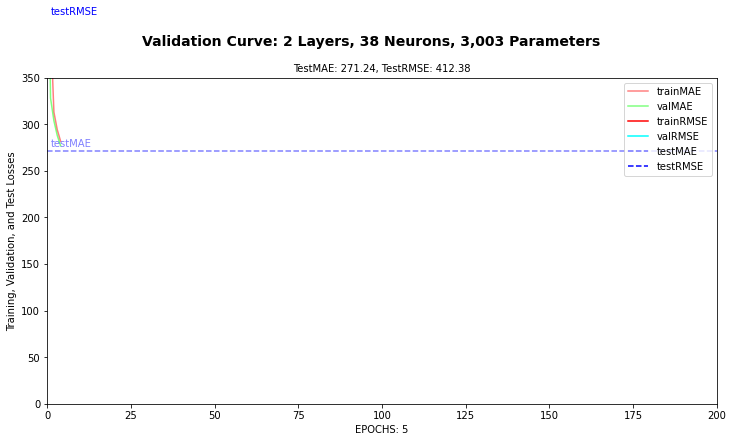

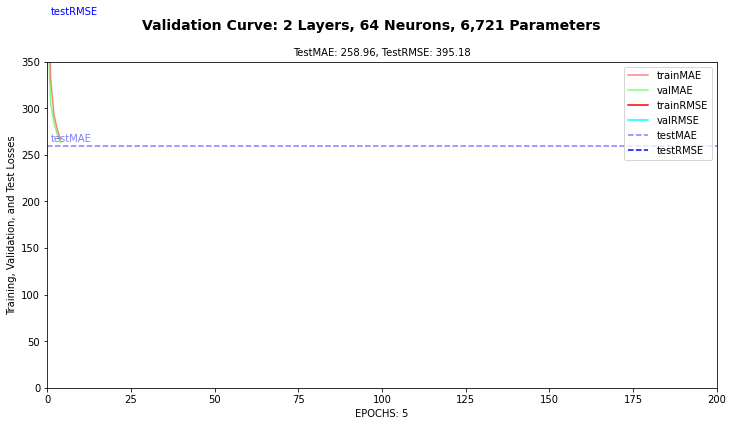

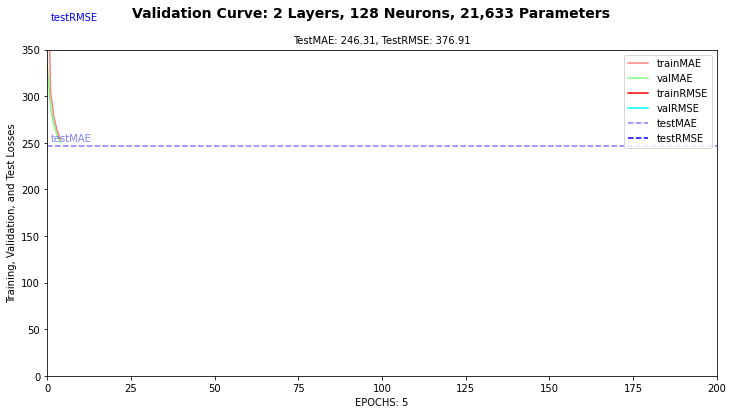

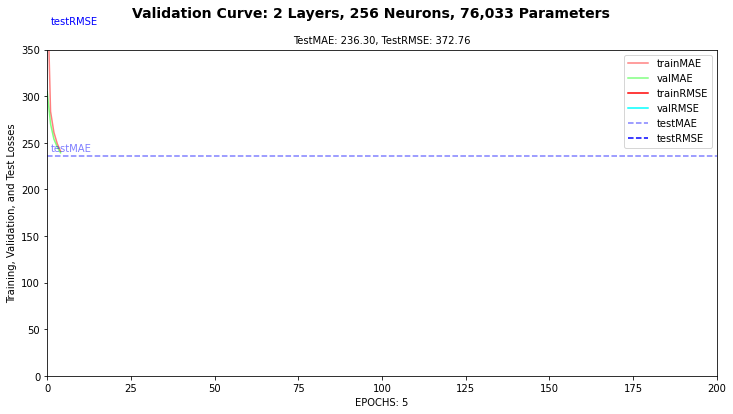

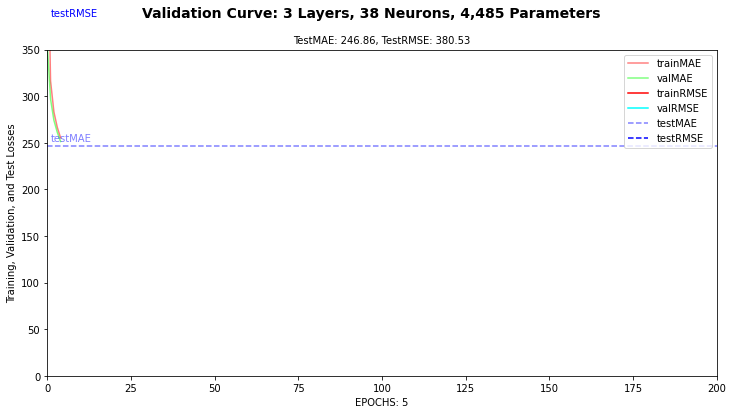

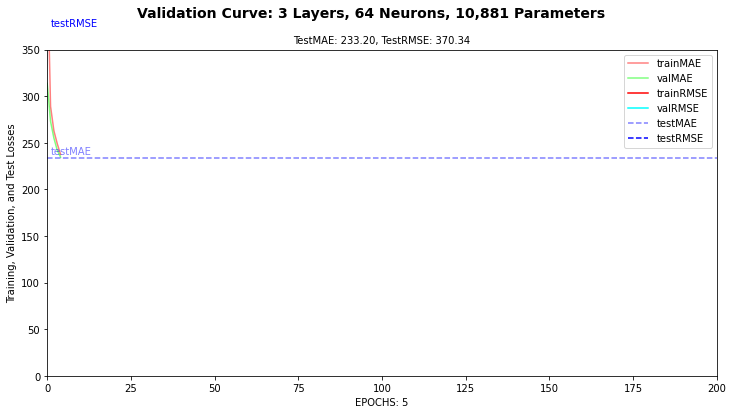

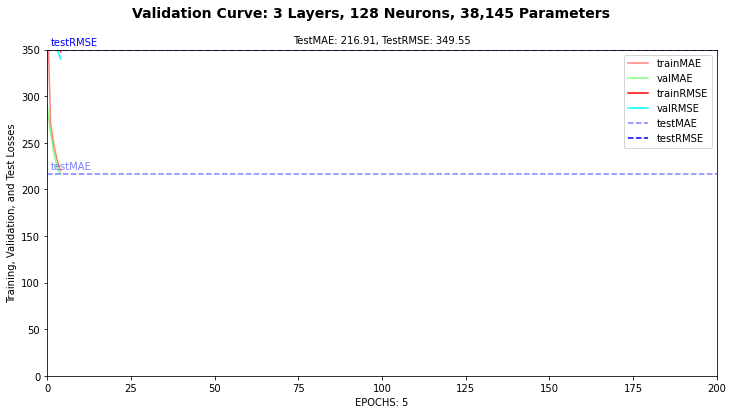

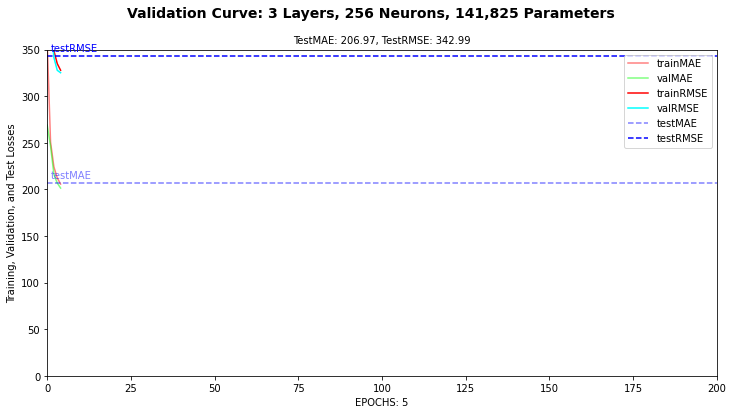

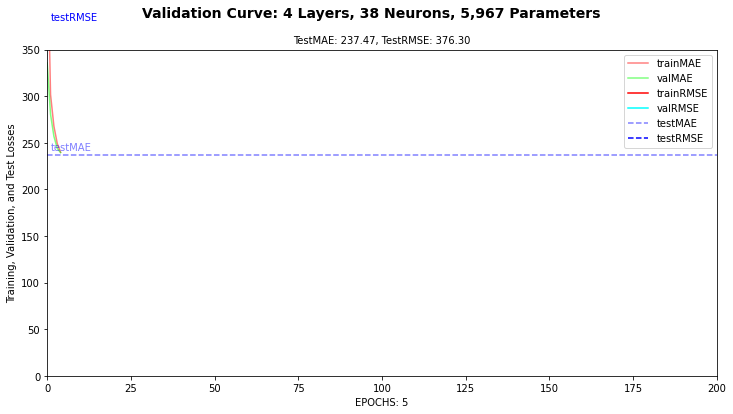

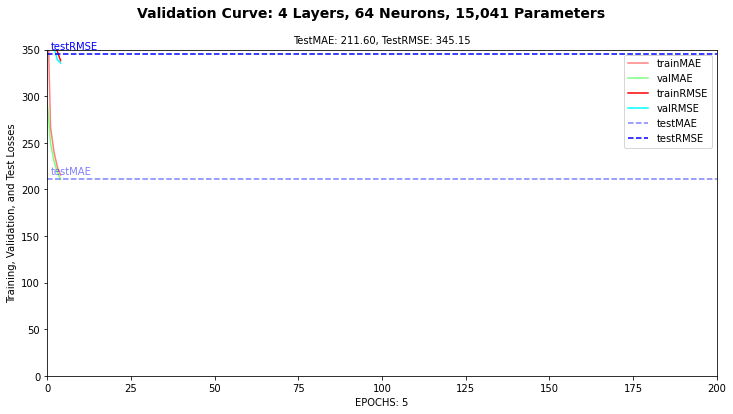

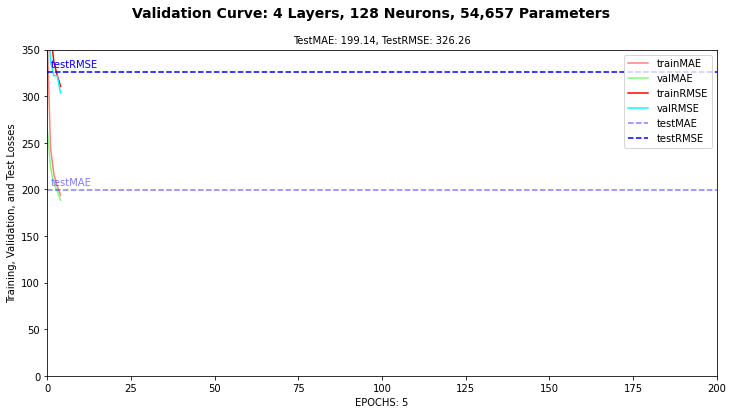

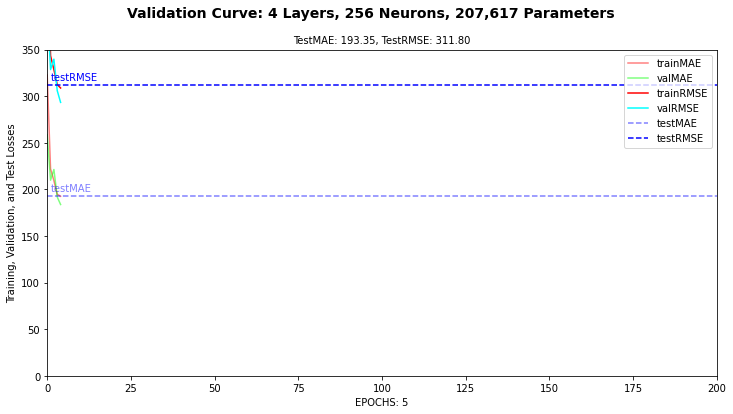

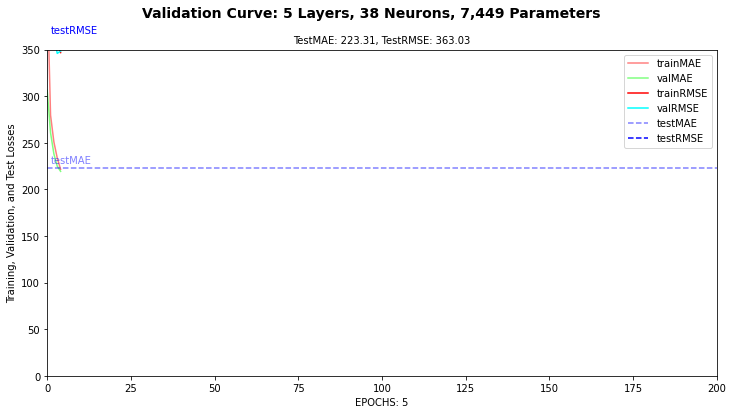

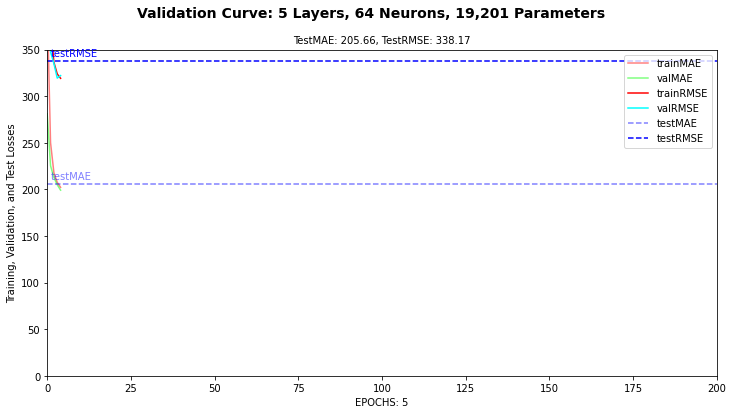

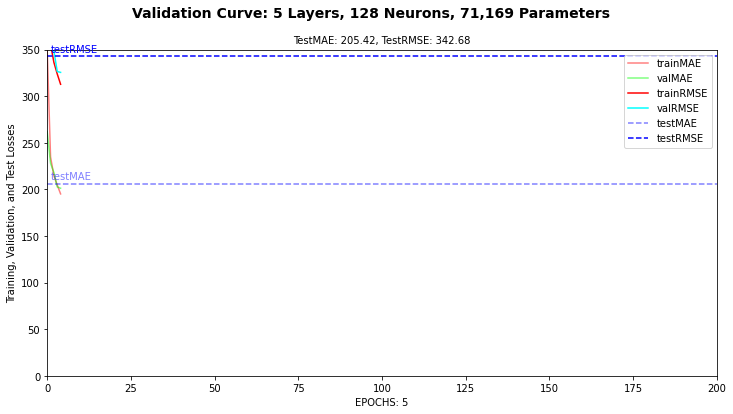

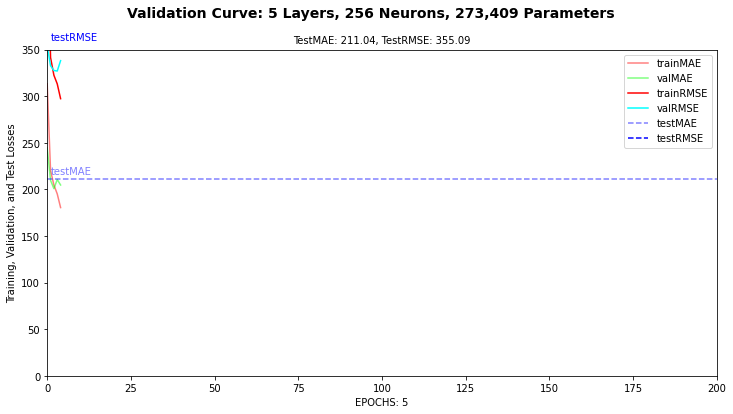

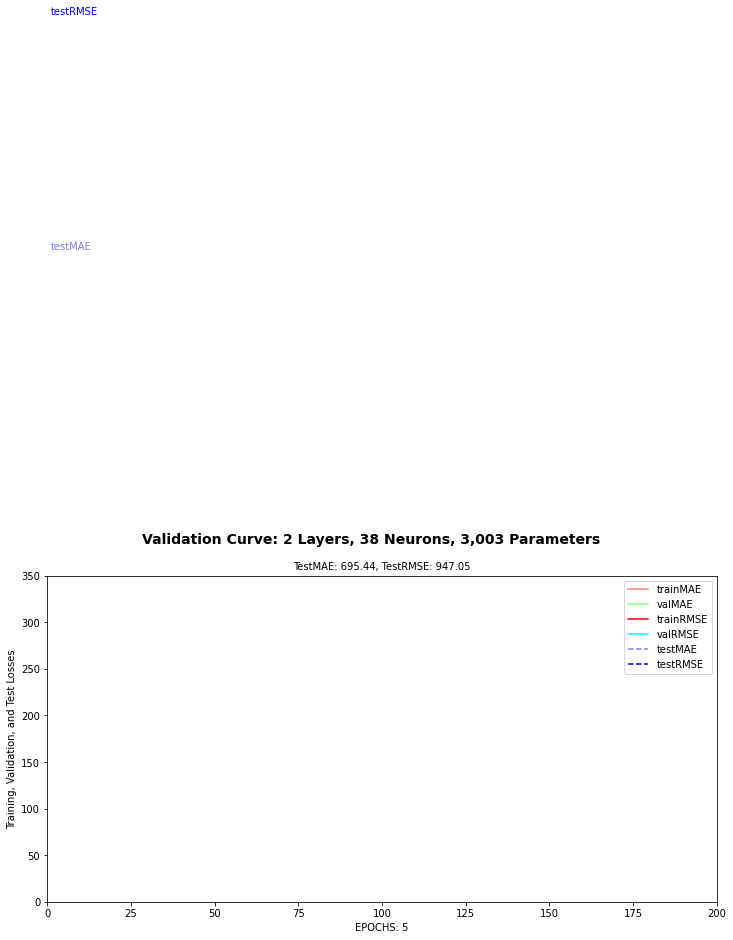

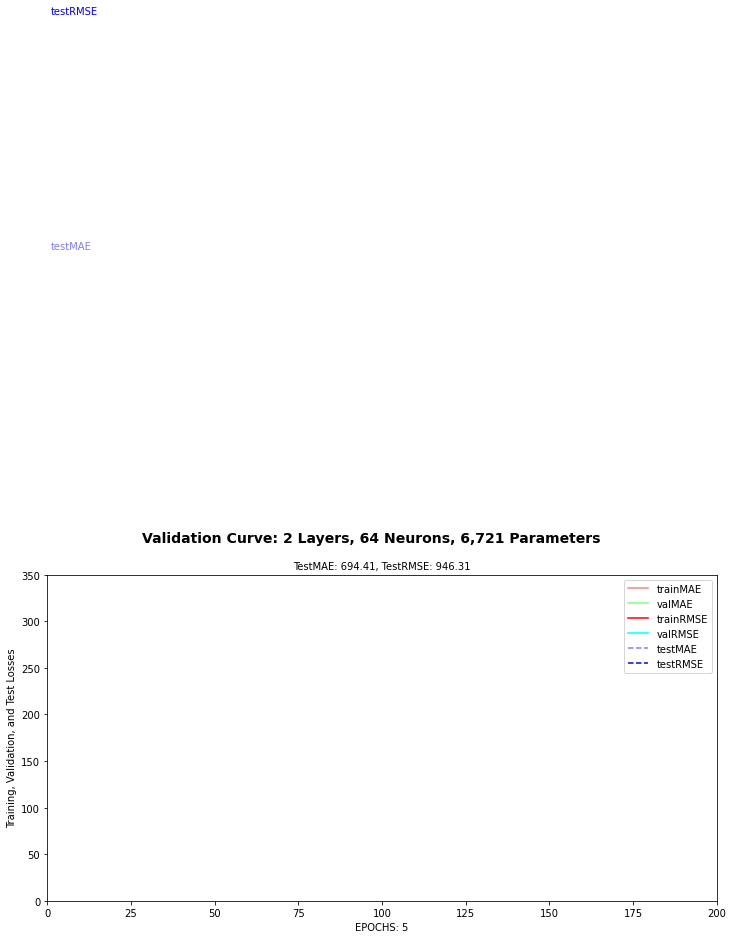

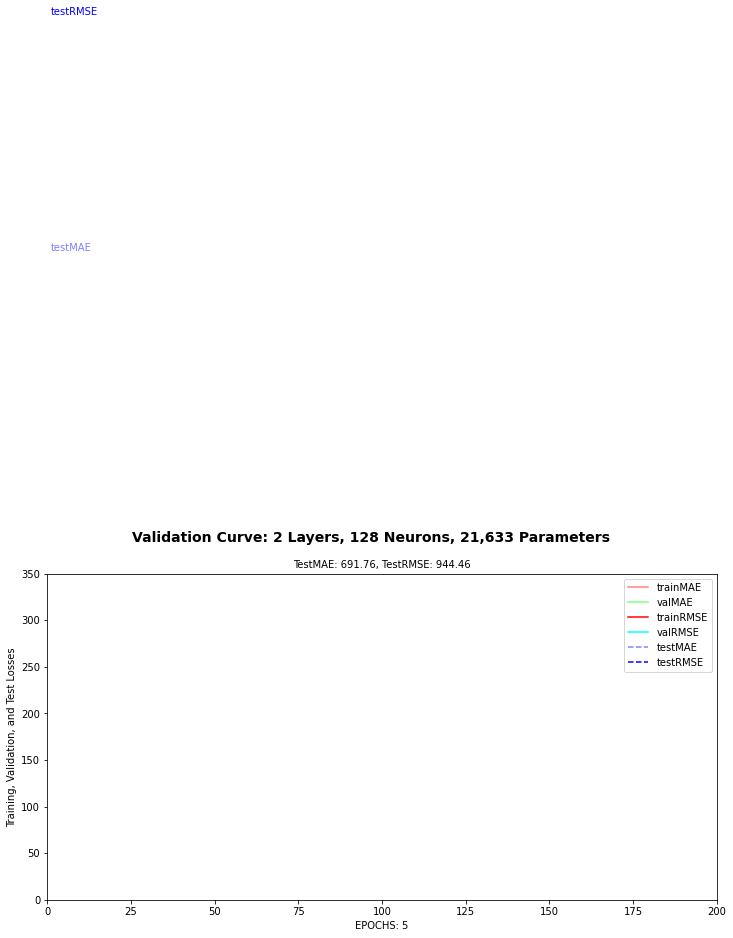

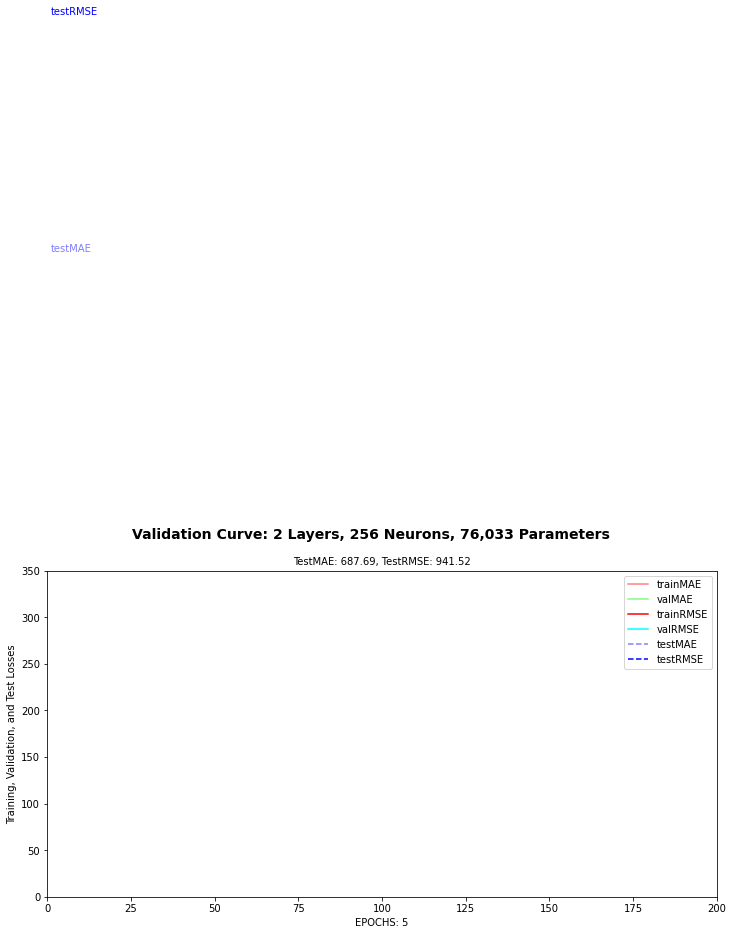

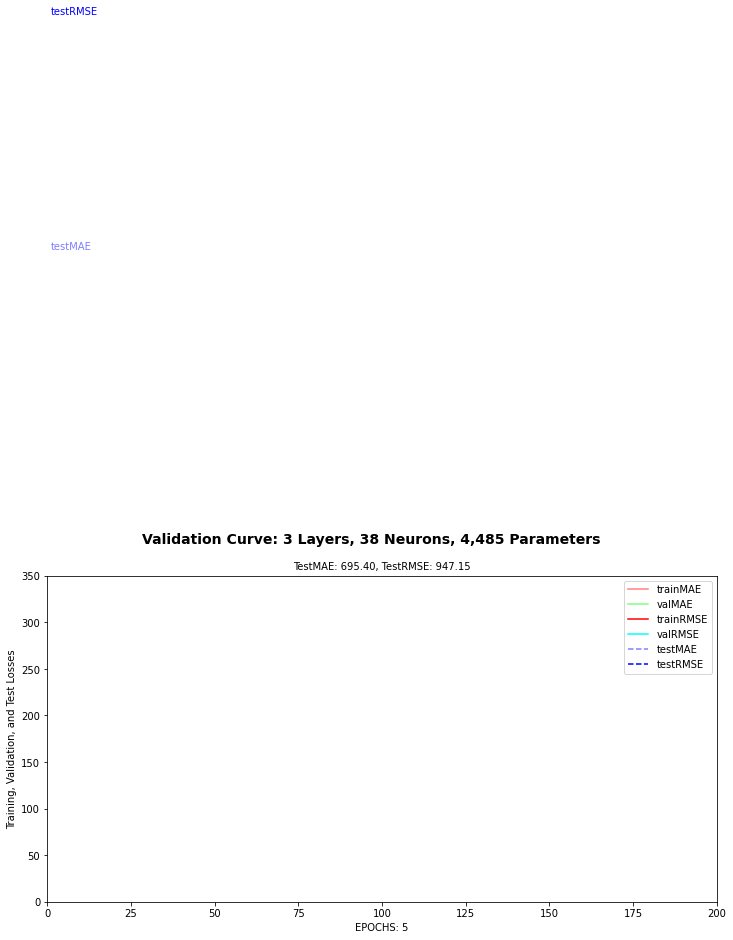

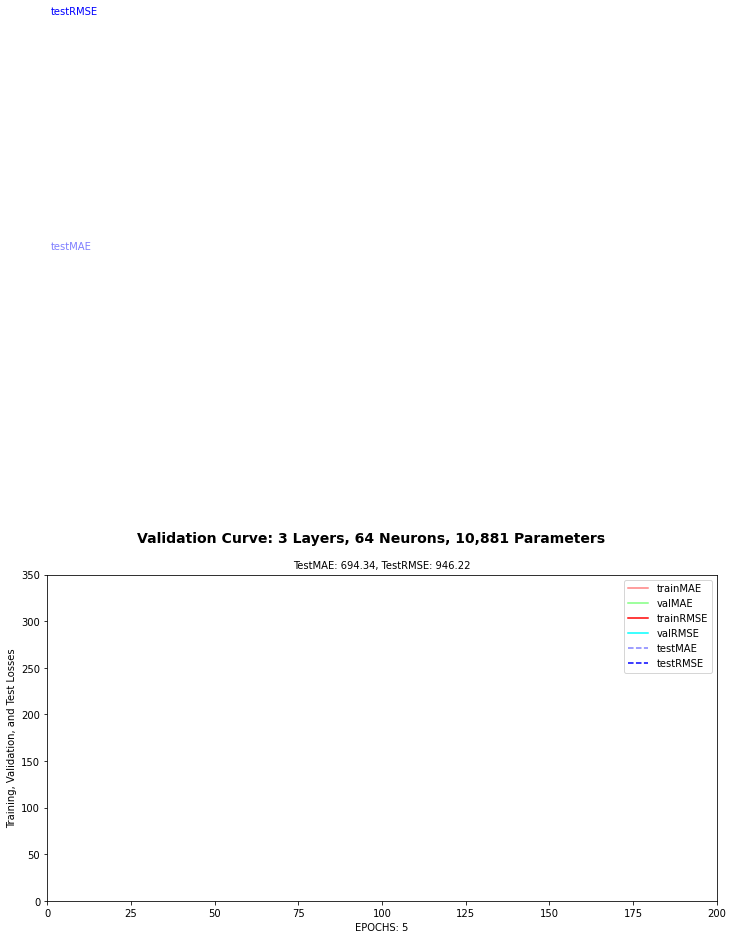

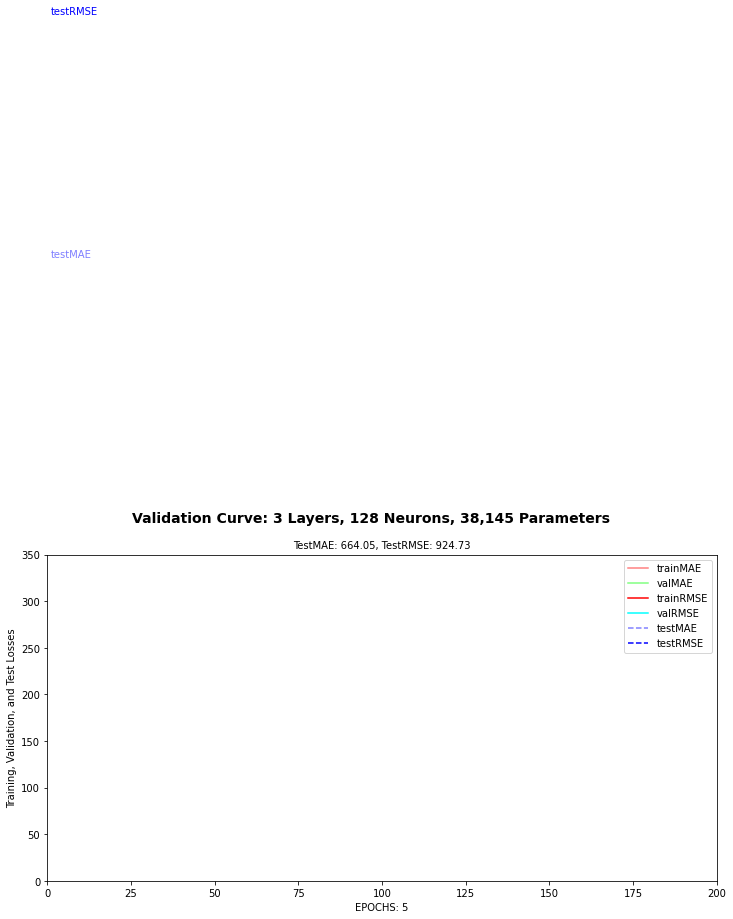

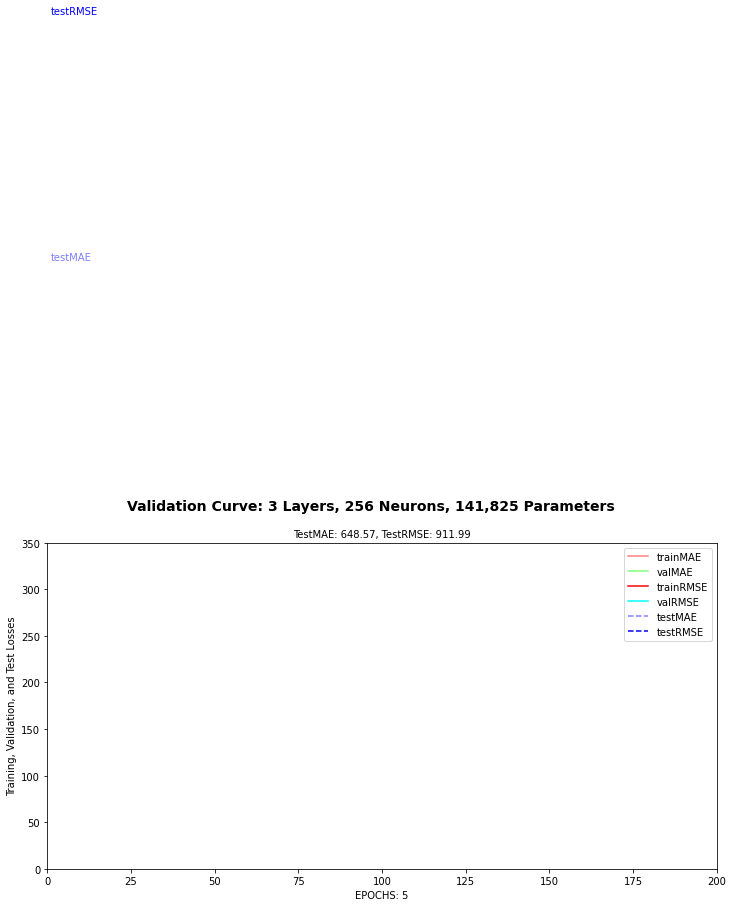

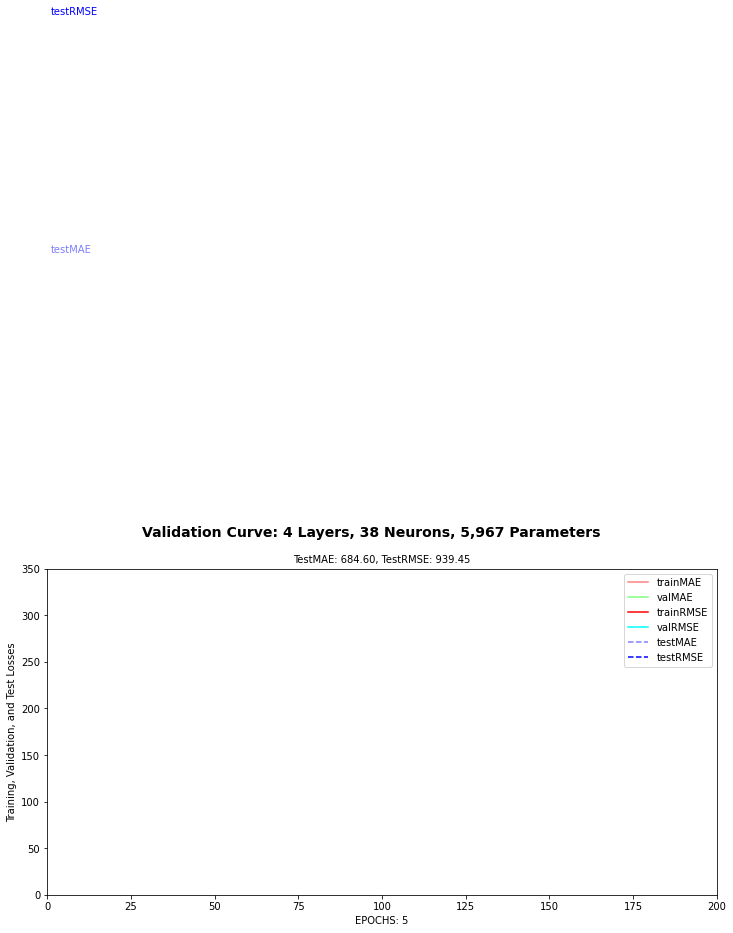

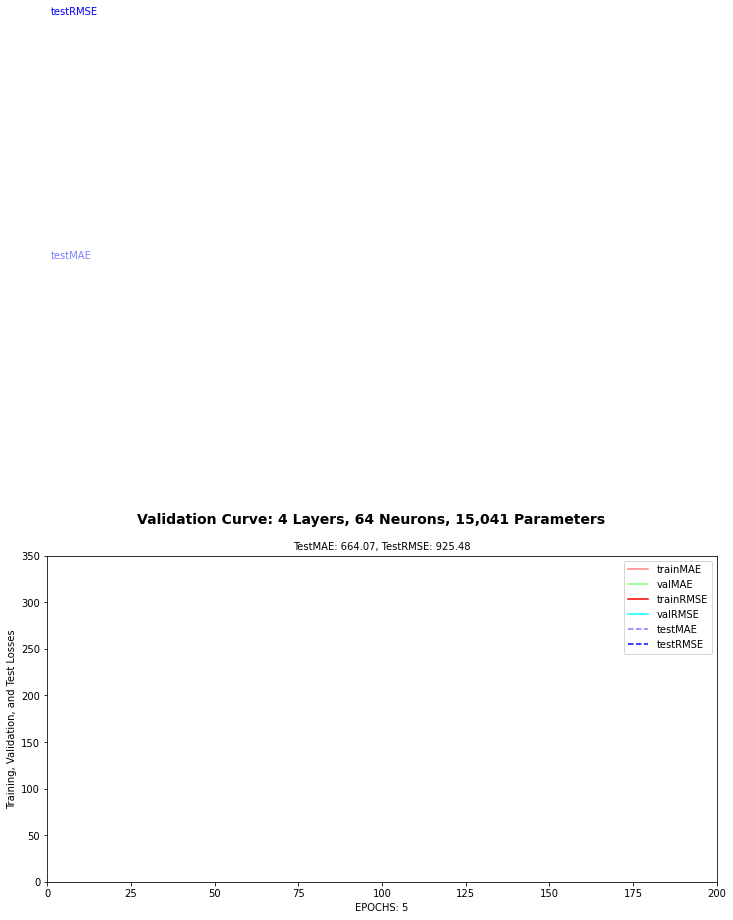

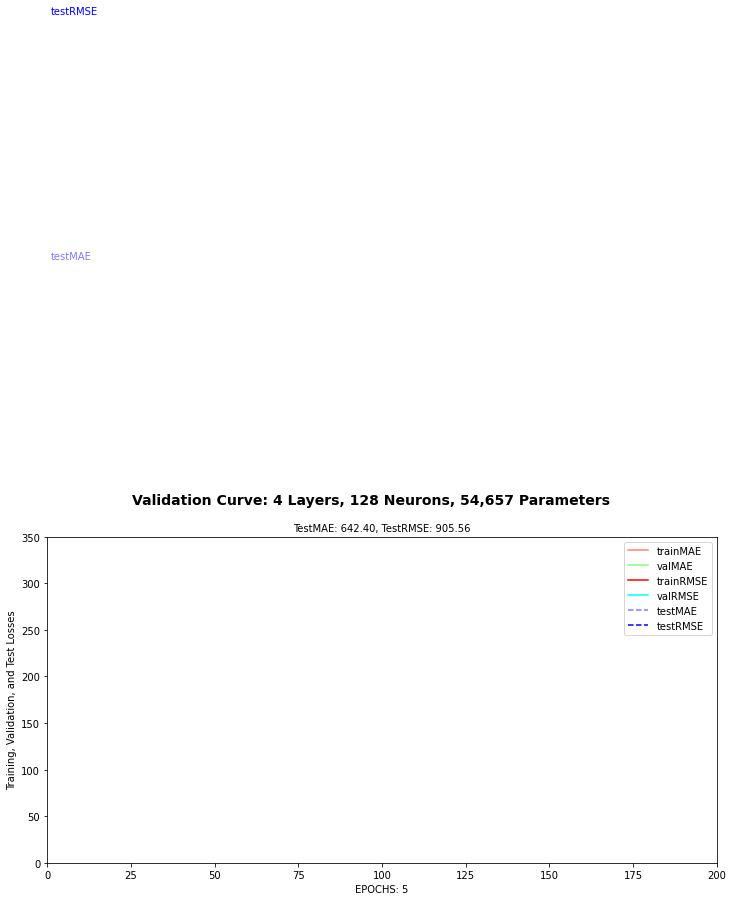

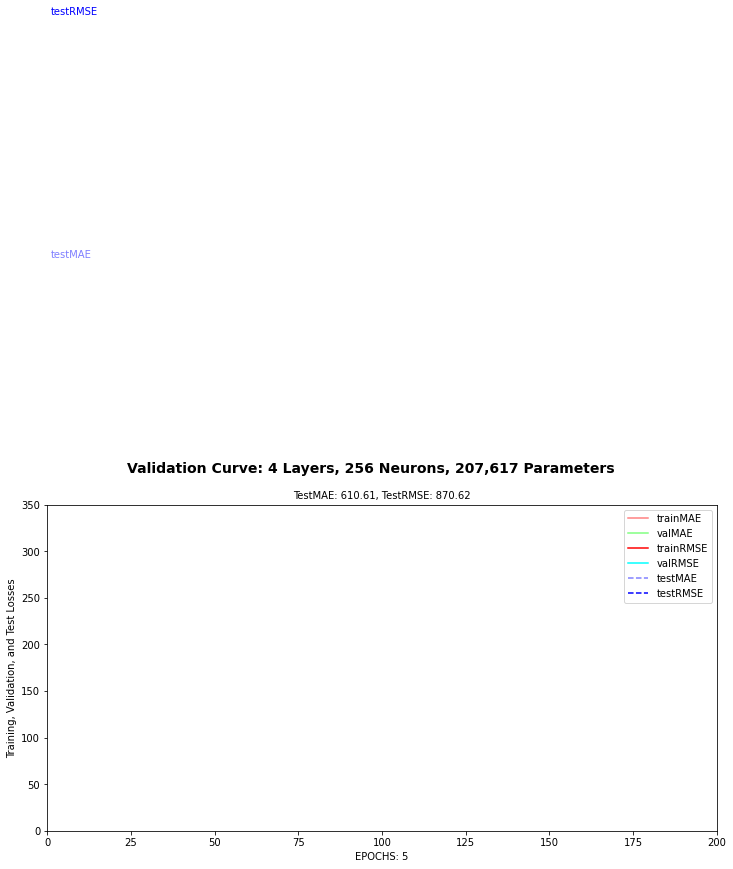

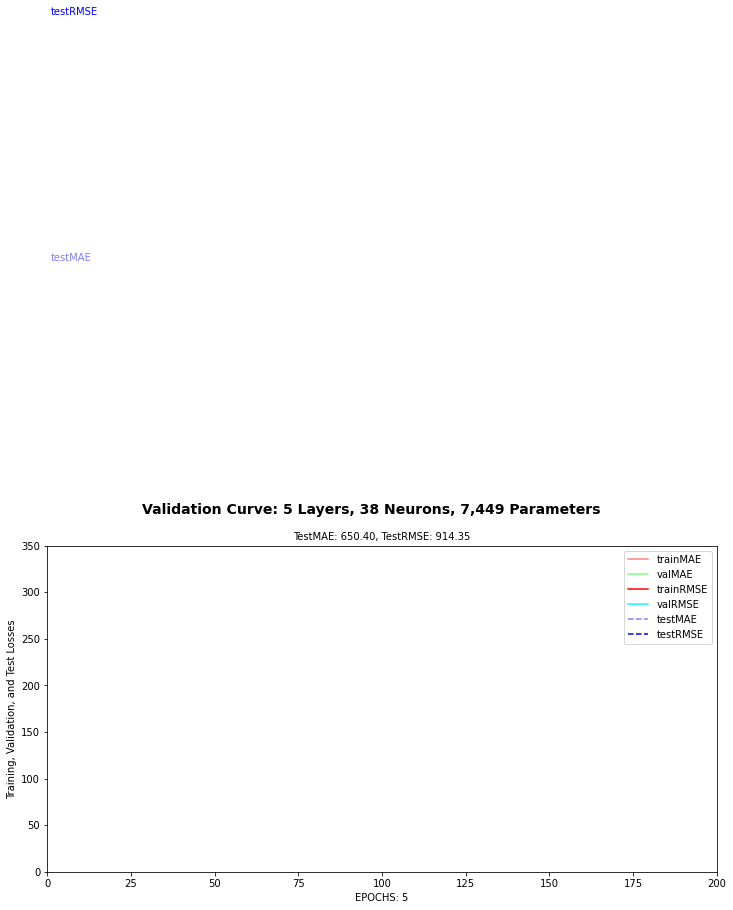

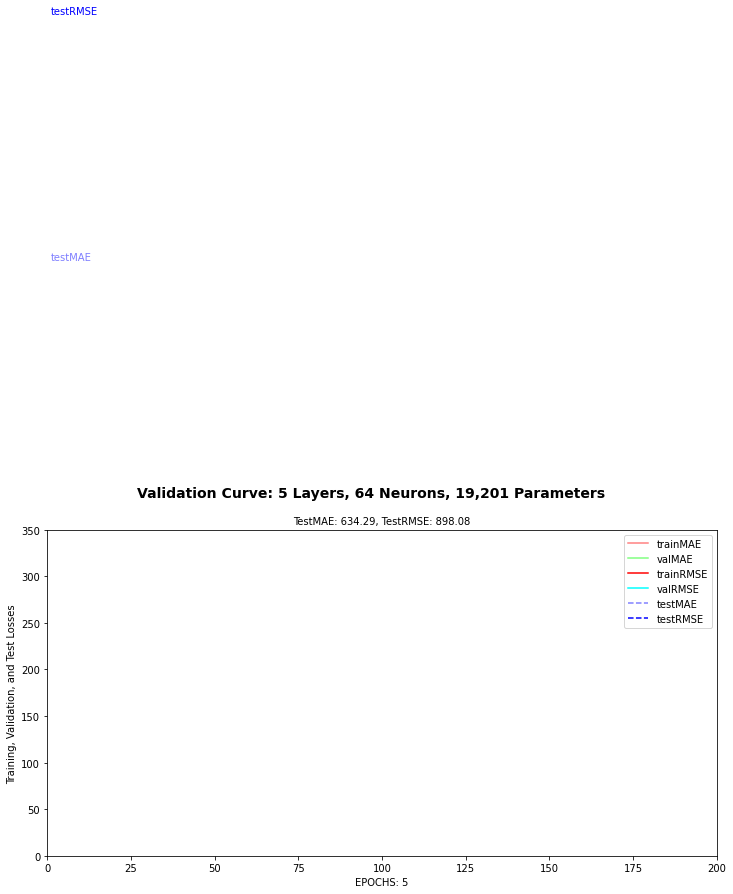

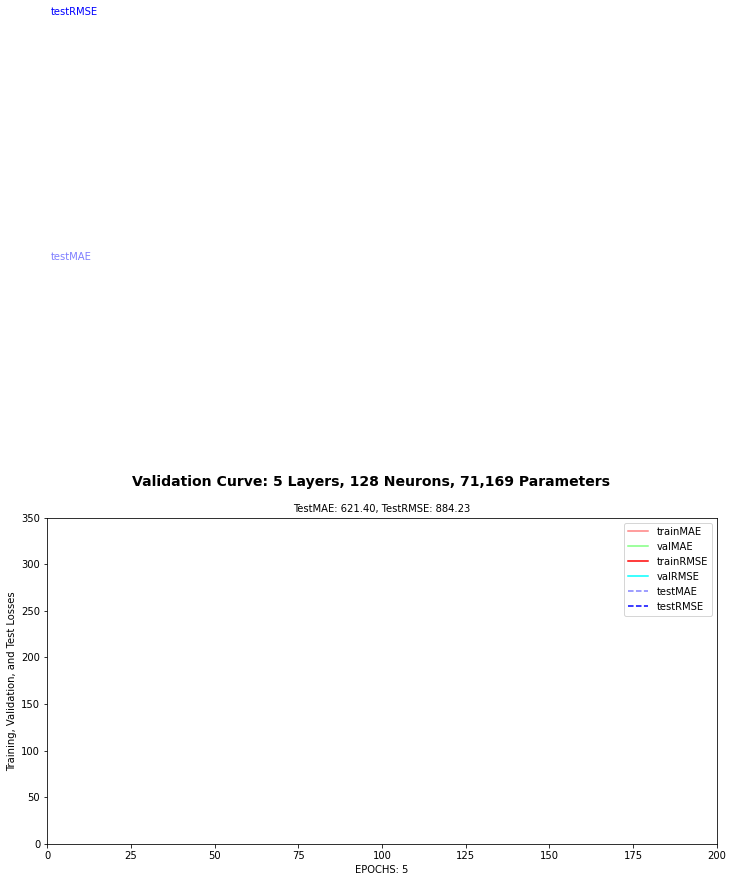

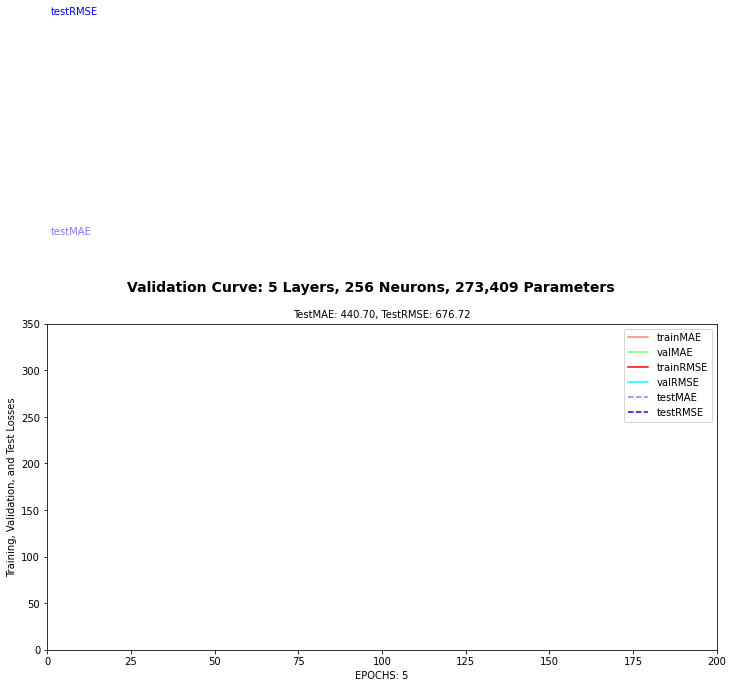

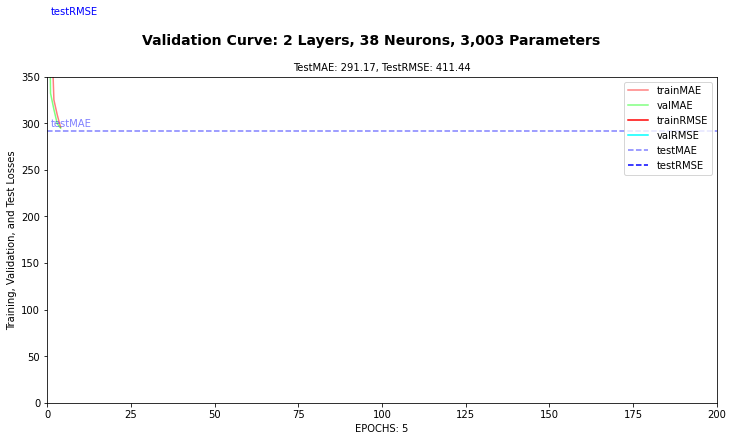

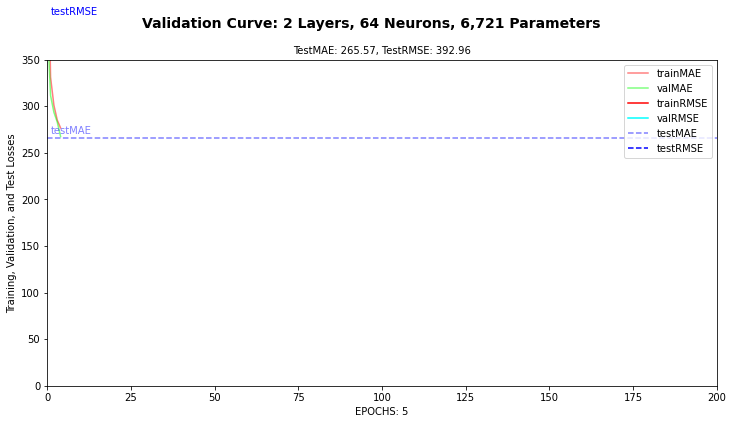

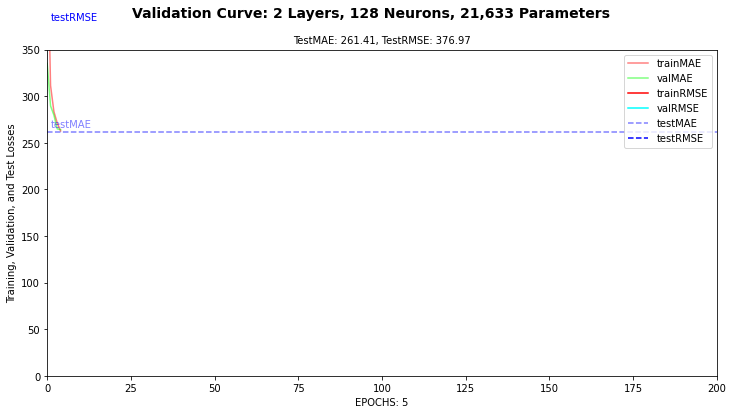

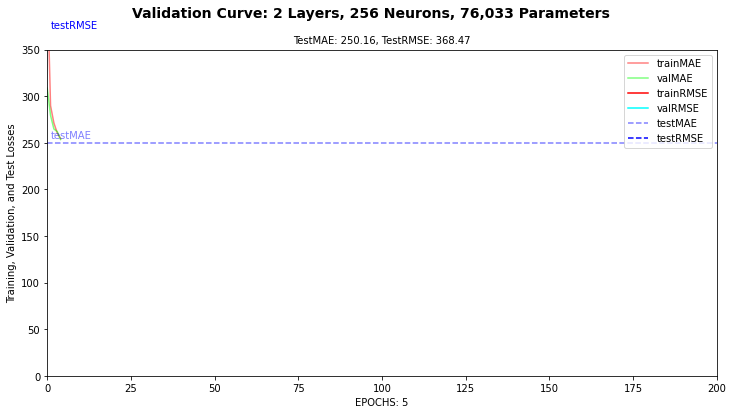

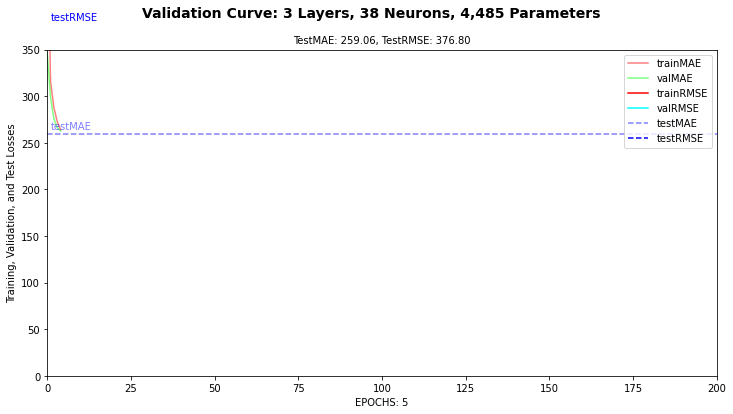

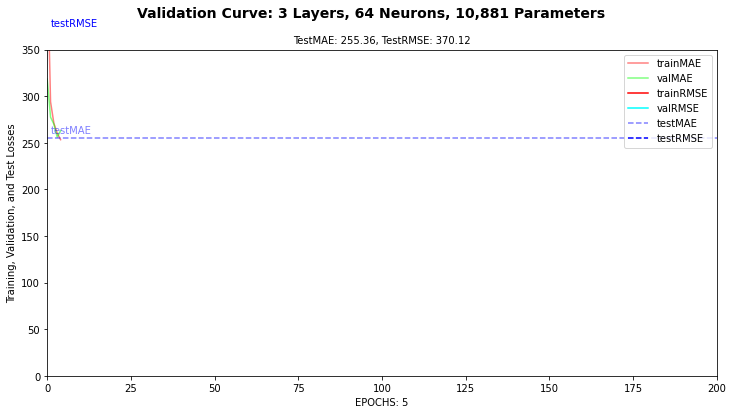

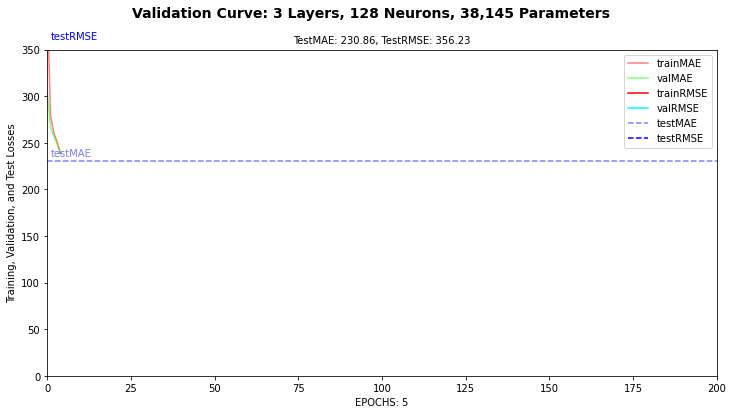

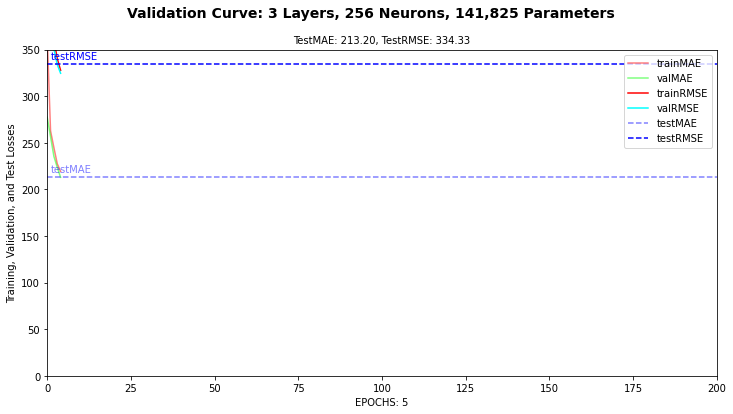

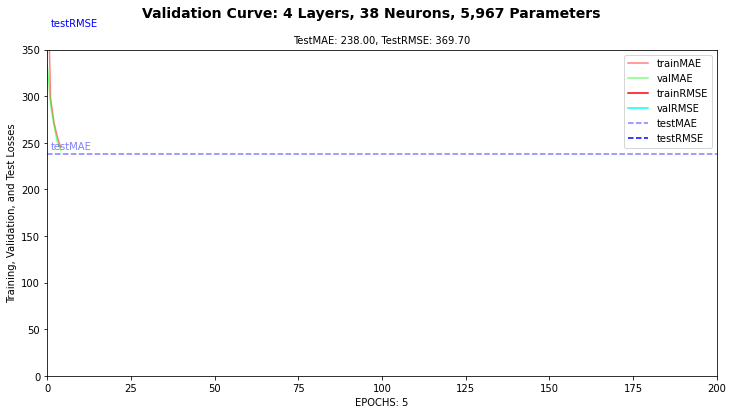

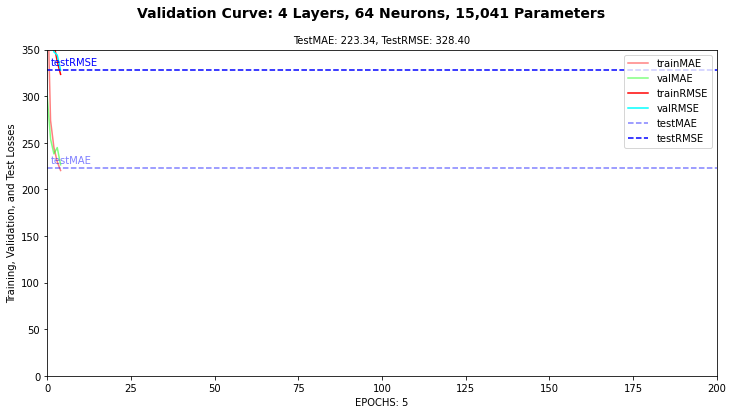

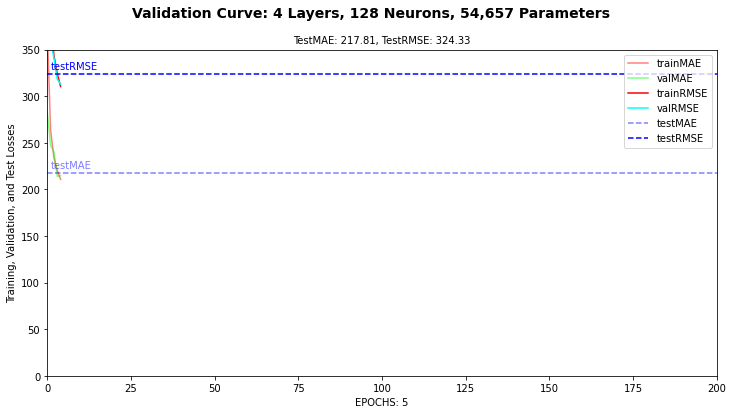

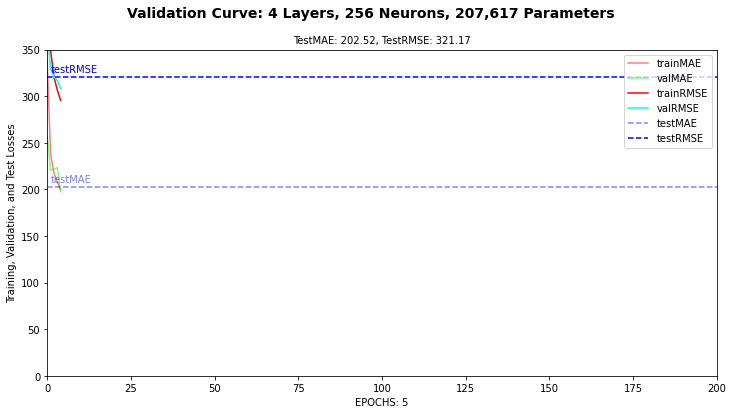

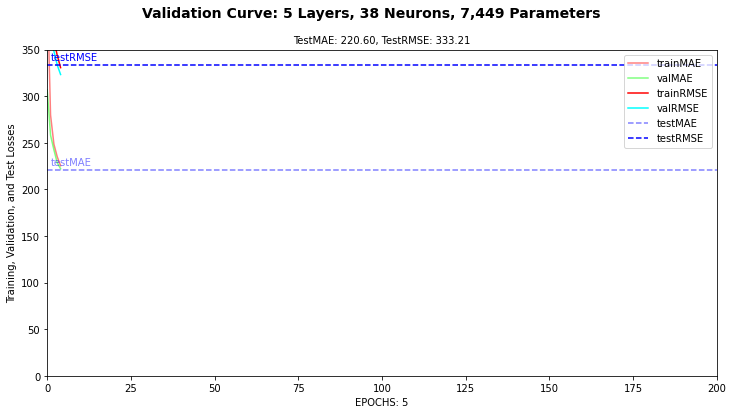

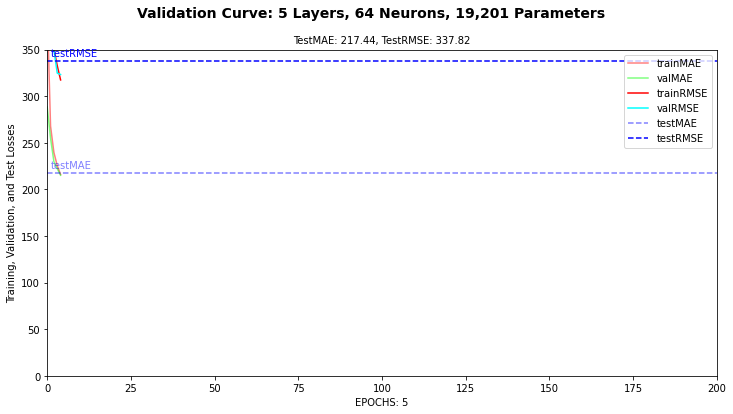

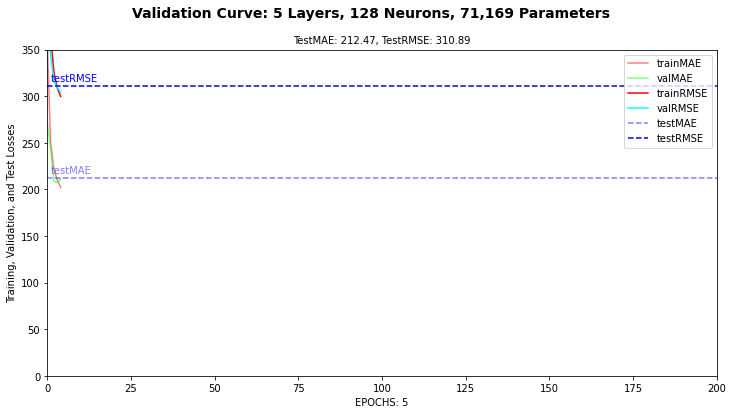

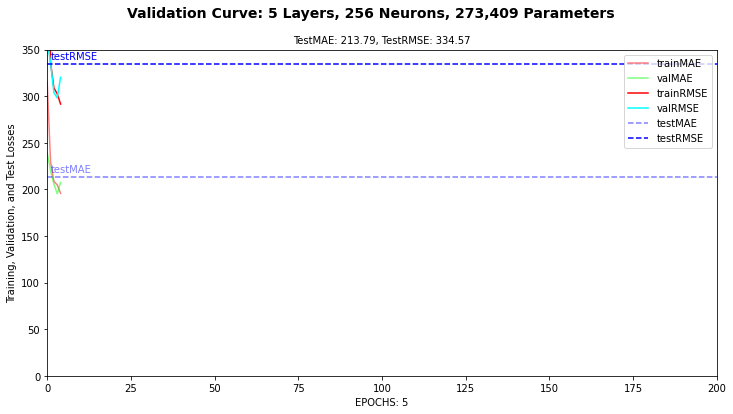

In [16]:
with tqdm(total=48+1, mininterval=1, unit='model') as pbar:
    
    for EPOCH in EPOCHS:
        for LOSS in LOSSES:
            for LAYER in LAYERS:
                for NEURON in NEURONS:
                        
                    pbar.set_description(f"Training for Epochs: {EPOCH}, Loss: {LOSS.name}, Layers: {LAYER}, Neurons: {NEURON}\n")
                    letTheLoopinBegin(EPOCH, LOSS, LAYER, NEURON)
                    pbar.update(1)